In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
state_sol = np.load("state_sol.npy")
control_sol = np.load("control_sol.npy")

In [11]:
state_sol.shape

(100, 6)

In [5]:
control_sol.shape

(3, 3)

In [10]:
control_sol

array([[ 1.32805646e-02, -1.13792519e-02,  2.14756649e-04],
       [ 3.05655260e-02, -1.58819362e-02, -1.18726992e-04],
       [-8.73823988e-05,  6.15696511e-04,  1.27808882e-04]])

In [7]:
t0 = 0.0
tf = 12.34 / 4.34811305 * 1.91 # time of flight
time = np.linspace(t0, tf, 100)

In [9]:
time.shape

(100,)

In [18]:
import sys
import os

# Construct the full path to the directory containing the package
project_path = '/workspace/apolune'

# Add the directory to sys.path
sys.path.append(project_path)


import numpy as np
from copy import deepcopy
from scipy.integrate import odeint
import dynamics.crtbp_dynamics as crtbp
import dynamics_coeff.dynamics_general_jit as dyn_coeff
import propagation.propagator as propagation
import cvxpy as cvx
import matplotlib.pyplot as plt
import spiceypy as spice
import init.load_kernels as krn
import dynamics_coeff.rnbp_rpf_utils as rnbp_utils
import time as tm
import scp_core
import dynamics_coeff.homotopy as homotopy
import scp_solve


def initial_guess(auxdata):
    n_x = auxdata['problem']['n_x']
    n_u = auxdata['problem']['n_u']
    n_man = auxdata['param']['n_man']
    
    time = auxdata['param']['time_vec']
    x0 = auxdata['param']['x0']
#     x0[3:6] *= 1.001 # converges
#     x0[3:6] *= 1.004 # failed
#     x0[3:6] *= 1.002 # converges
    x0[3:6] *= 0.99994195

#     x0[3:6] *= 1.002445 # converges for crtbp when propagating nb dynamics
#     x0 *= 1.000005 # 
    
    
    if auxdata['problem']['free_tf'] == 1:
        tf = auxdata['param']['tf']
        time = time * tf
        p_guess = np.array([tf])
    else:
        p_guess = np.empty(0)
    
    u_guess = np.zeros((n_man, n_u))
    x_guess = propagation.propagate(crtbp.dynamics, x0, u_guess, p_guess, time, auxdata)
#     x_guess = propagation.propagate(dyn_coeff.dynamics, x0, u_guess, p_guess, time, auxdata)
    

    return x_guess, u_guess, p_guess



mu_earth_moon = 1.21506683e-2
LU = 3.84405000e5 # km
TU = 4.34811305 # days
VU = 1.02323281 # km/s

# crtbp
mu = mu_earth_moon

# bcrfbp
mu_sun = 3.28900541e5 # adim
a_sun = 3.88811143e2 # adim
om_sun = -9.25195985e-1
sun_angle_t0 = 0.0

# rnbp_rpf
krn.load_kernels()

G = 6.67408e-20  # [km^3 kg^−1 s^−2]
# AU = 149597870.693 # km
AU = 1.495978706136889e+08 # [km] from SPICE

observer_id = 0

# (index, spice_id) pairs
id_mer = [0, 1]
id_ven = [1, 2]
id_ear = [2, 399]
id_mar = [3, 4]
id_jup = [4, 5]
id_sat = [5, 6]
id_ura = [6, 7]
id_nep = [7, 8]
id_plu = [8, 9]
id_moo = [9, 301]
id_sun = [10, 10]

# Standard gravitational parameter ( μ [km^3 s−2] )
GM_sun = spice.bodvrd(str(id_sun[1]), "GM", 1)[1][0] 
GM_mer = spice.bodvrd(str(id_mer[1]), "GM", 1)[1][0] 
GM_ven = spice.bodvrd(str(id_ven[1]), "GM", 1)[1][0] 
GM_ear = spice.bodvrd(str(id_ear[1]), "GM", 1)[1][0] 
GM_moo = spice.bodvrd(str(id_moo[1]), "GM", 1)[1][0] 
GM_mar = spice.bodvrd(str(id_mar[1]), "GM", 1)[1][0] 
GM_jup = spice.bodvrd(str(id_jup[1]), "GM", 1)[1][0] 
GM_sat = spice.bodvrd(str(id_sat[1]), "GM", 1)[1][0] 
GM_ura = spice.bodvrd(str(id_ura[1]), "GM", 1)[1][0] 
GM_nep = spice.bodvrd(str(id_nep[1]), "GM", 1)[1][0] 
GM_plu = spice.bodvrd(str(id_plu[1]), "GM", 1)[1][0] 

id_primary = id_ear[0]
id_secondary = id_moo[0]

id_bodies = np.array([id_mer[0], id_ven[0], id_ear[0], id_mar[0], id_jup[0], id_sat[0], id_ura[0], id_nep[0], id_plu[0], id_moo[0], id_sun[0]])
naif_id_bodies = np.array([id_mer[1], id_ven[1], id_ear[1], id_mar[1], id_jup[1], id_sat[1], id_ura[1], id_nep[1], id_plu[1], id_moo[1], id_sun[1]])
mu_bodies = np.array([GM_mer, GM_ven, GM_ear, GM_mar, GM_jup, GM_sat, GM_ura, GM_nep, GM_plu, GM_moo, GM_sun])

MU = mu_bodies[id_primary] + mu_bodies[id_secondary]

# epoch_t0 = spice.str2et('23 September 2022 00:00:00 TDB')
epoch_t0 = spice.str2et('1 June 2024 00:00:00 TDB')
reference_frame = "j2000"
reference_frame_encoded = rnbp_utils.frame_encoder("J2000")
mu_p = mu_bodies[id_primary]
mu_s = mu_bodies[id_secondary]
naif_id_p = naif_id_bodies[id_primary]
naif_id_s = naif_id_bodies[id_secondary]

ode_rtol = 1e-12
ode_atol = 1e-12
tau_0 = 0.0
tau_f = 100.0
t0 = 0.0
n_points = 5000
tau_vec_input = np.linspace(tau_0, tau_f, n_points)
tau_vec, t_vec = rnbp_utils.compute_time(tau_vec_input, t0, epoch_t0, mu_p, mu_s, naif_id_p, naif_id_s, reference_frame, ode_rtol = ode_rtol, ode_atol = ode_atol)


n_x = 6
n_u = 3
N = 100
Ns = N - 1

# 0: fixed final time, 1: free final time
# NOTE: i only implemented the case for free_tf = 0 so far
free_tf = 0

# model = 1 # crtbp
# model = 2 # bcrfbp
# model = 3 # rnbp_rpf
model = 3 # rnbp_rpf with fft, interpolation, and homotopy

if model == 4: 
    # Define parameters for approximation methods
    n_components_fft = 100 # not used for now since not removing high frequency components
    num_segments_piecewise = 20
    polynomial_degree = 3
    
    # Select homotopy method and extrapolation point
    sel_homotopy = 1 # 1: FFT ; 2: Piecewise ; 3: Polynomial
    if sel_homotopy == 1:
        homotopy_param = n_components_fft
    elif sel_homotopy == 2:
        homotopy_param = num_segments_piecewise
    elif sel_homotopy == 3:
        homotopy_param = polynomial_degree
    
    coeff_3bp_tmp, coeff_nbp_list, f_precomputed_list = homotopy.get_homotopy_coefficients(sel_homotopy, homotopy_param, tau_vec, t_vec, id_primary, id_secondary, mu_bodies, naif_id_bodies, observer_id, reference_frame_encoded, epoch_t0, use_jit=True)
    coeff_nbp = np.array((coeff_nbp_list), dtype=np.float64)
    f_precomputed = np.array((f_precomputed_list), dtype=np.float64)
    coeff_3bp = np.ascontiguousarray(coeff_3bp_tmp)



# node indices where maneuvers are applied; numpy array within [0, Ns]
# man_index = np.array([0, 30, 60, Ns])
man_index = np.array([0, 50, Ns])
# man_index = np.array([0, Ns])

# initial and final boundary conditions
# x0 = np.array([8.2338046140454002e-01, 0, 1.3886061447073000e-02, 0, 1.2947638542136800e-01, 0]) # adim
# xf = np.array([1.1194488032482977e+00, 2.3502976908423845e-13, -1.1371675247773910e-02, 2.2969820490104098e-13, 1.7876223257953414e-01, -2.7620527393024119e-13]) # adim
# t0 = 0.0
# tf = 6.9083604301186052e-01

x0 = np.array([0.870183, -0.059444, 0, -0.010471, -0.175136, 0]) # adim
xf = np.array([1.11559, -0.056398, 0, -0.008555, 0.157211, 0]) # adim
t0 = 0.0
tf = 12.34 / TU * 1.91 # time of flight

# tf = 12.34 / TU * 1.95 # time of flight

# bounds for states, controls, and dv per maneuver
states_lower = -10.0 * np.ones(n_x)
states_upper = 10.0 * np.ones(n_x)
controls_lower = -10.0 * np.ones(n_u)
controls_upper = 10.0 * np.ones(n_u)
# dv_max = 0.5
dv_max = 0.05
# dv_max = 0.06

# n_p: number of free parameters in the optimization
# here: no free parameters
n_man = len(man_index)
n_p = 0

tf_ind = 0

# lower and upper bounds of the free variable vector p
p_lower = np.empty(0)
p_upper = np.empty(0)

# functions for dynamics and corresponding jacobian
jacobian_x_function = dyn_coeff.jacobian
dynamics_function = dyn_coeff.dynamics

# tolerances for the integrator
# we use different values for piecewise integration (from t_k to t_k+1) and full integration (from t0 to tf)
ode_atol_piecewise = 1e-10
ode_rtol_piecewise = 1e-10
ode_atol = 1e-12
ode_rtol = 1e-12

# discretized time vector
time = np.linspace(t0, tf, N)

# trust region parameters
tr_dict = {}
tr_dict['radius'] = 100.0
tr_dict['rho'] = 100.0
tr_dict['rho0'] = 0.01
tr_dict['rho1'] = 0.2
tr_dict['rho2'] = 0.85
tr_dict['alpha'] = 1.5
tr_dict['beta'] = 1.5
tr_dict['delta'] = 1.0
tr_dict['alpha_min'] = 1.01
tr_dict['alpha_max'] = 4.0
tr_dict['beta_min'] = 1.01
tr_dict['beta_max'] = 4.0
tr_dict['radius_min'] = 1e-7
tr_dict['radius_max'] = 500.0


# -----
# some internal definitions -> probably no need to change anything here for now

x_len = N*n_x
u_len = n_man*n_u
t_len = 0
p_len = n_p

xu_len = x_len + u_len
sol_len = xu_len + t_len + p_len
x_ind = slice(0, x_len) 
u_ind = slice(x_len, xu_len)
p_ind = slice(xu_len, xu_len+p_len)
tf_ind_sol = xu_len + tf_ind

stm_x_len = n_x*n_x
stm_t_len = n_x * free_tf
stm_const_len = n_x

V_len = n_x + stm_x_len + stm_t_len + stm_const_len
    
x_ind_stm = slice(0, n_x)
stm_x_ind = slice(n_x, stm_x_len+n_x)
stm_t_ind = slice(stm_x_len+n_x, stm_x_len+n_x+stm_t_len)
stm_const_ind = slice(stm_x_len+n_x+stm_t_len, stm_x_len+n_x+stm_t_len+stm_const_len)

V0 = np.zeros(V_len);
V0[stm_x_ind] = np.identity(n_x).flatten()
 
x_stm = np.zeros((N,n_x));
stm_x = np.zeros((Ns,n_x*n_x));
stm_t = np.zeros((Ns,stm_t_len));
stm_const = np.zeros((Ns,stm_const_len));

if free_tf == 1:
    time = np.linspace(0.0, 1.0, N)
else:
    time = np.linspace(t0, tf, N)

if man_index[0] == 0:
    man_index_defects = man_index[1:]
    n_man_defects = n_man - 1
else:
    man_index_defects = man_index
    n_man_defects = n_man



In [24]:

scaling_dict = {'LU': LU, 'VU': VU, 'TU': TU}
lengths_dict = {'x_len': x_len, 'u_len': u_len, 'xu_len': xu_len, 'p_len': p_len, 't_len': t_len, 'sol_len': sol_len, 'stm_x_len': stm_x_len, 'stm_t_len': stm_t_len, 'stm_const_len': stm_const_len, 'V_len': V_len}
indices_dict = {'x_ind': x_ind, 'u_ind': u_ind, 'p_ind': p_ind, 'tf_ind': tf_ind, 'tf_ind_sol': tf_ind_sol, 'x_ind_stm': x_ind_stm, 'stm_x_ind': stm_x_ind, 'stm_t_ind': stm_t_ind, 'stm_const_ind': stm_const_ind}
problem_dict = {'n_x': n_x, 'n_u': n_u, 'n_p': n_p, 'N': N, 'Ns': Ns, 'free_tf': free_tf, \
    'dynamics': dynamics_function, 'jacobian_x': jacobian_x_function}
param_dict = {'mu': mu, 't0': t0, 'tf': tf, 'x0': x0, 'xf': xf, 'time_vec': time, 'n_man': n_man, 'man_index': man_index, \
    'n_man_defects': n_man_defects, 'man_index_defects': man_index_defects, 'dv_max': dv_max, \
    'ode_atol': ode_atol, 'ode_rtol': ode_rtol, 'ode_atol_piecewise': ode_atol_piecewise, 'ode_rtol_piecewise': ode_rtol_piecewise}
boundaries_dict = {'states_lower': states_lower, 'states_upper': states_upper, 'controls_lower': controls_lower, 'controls_upper': controls_upper, \
    'p_lower': p_lower, 'p_upper': p_upper}
discretization_dict = {'V0': V0, 'x': x_stm, 'stm_x': stm_x, 'stm_t': stm_t, 'stm_const': stm_const}

auxdata = {'problem': problem_dict, 'lengths': lengths_dict, 'indices': indices_dict, 'param': param_dict, 'discretization': discretization_dict, 'boundaries': boundaries_dict, \
    'scaling': scaling_dict}

# for bcrfbp
auxdata["model"] = model
auxdata["mu_crtbp"] = mu
auxdata["mu_sun"] = mu_sun
auxdata["om_sun"] = om_sun
auxdata["sun_angle_t0"] = sun_angle_t0
auxdata["a_sun"] = a_sun

# for rnbp_rpf
auxdata["id_primary"] = id_primary
auxdata["id_secondary"] = id_secondary
auxdata["mu_bodies"] = mu_bodies
auxdata["naif_id_bodies"] = naif_id_bodies
auxdata["observer_id"] = observer_id
auxdata["reference_frame"] = reference_frame # needed if no numba / jit is used
# auxdata["reference_frame"] = reference_frame_encoded # needed for numba and jit
auxdata["epoch_t0"] = epoch_t0
auxdata["tau_vec"] = tau_vec
auxdata["t_vec"] = t_vec

#for homotopy
if model == 4:
    homot_param = 0 # Homotopy parameter (0 <= eps <= 1), would update this with a function in the future
    auxdata['coeff_3bp'] = coeff_3bp
    auxdata['coeff_nbp'] = coeff_nbp
    auxdata['f_precomputed'] = f_precomputed
    auxdata['homot_param'] = 0.0
    auxdata['sel_homotopy'] = sel_homotopy

# print("coeff_3bp.shape: ", coeff_3bp.shape)
# print("coeff_nbp.shape: ", coeff_nbp.shape)
# print("f_precomputed.shape: ", f_precomputed.shape)

# print("type coeff_3bp: ", type(coeff_3bp))
# print("type coeff_nbp: ", type(coeff_nbp))
# print("type f_precomputed: ", type(f_precomputed))

# generate initial guess 
state_guess, control_guess, p_guess = initial_guess(auxdata)

guess_dict = {}
guess_dict['state'] = state_guess
guess_dict['control'] = control_guess
guess_dict['p'] = p_guess
guess_dict['time'] = time


In [25]:
from dynamics_coeff.dynamics_general import dynamics as dyn_prop 

In [69]:
man

(100, 6)

In [79]:
patched_solution = np.zeros([100 * 99 + 1, 6])
patched_solution[-1, :] = state_sol[-1,:]
man_index = {0: 0, 50: 1, 99:2}
for i in range(0, 99):
    control_guess = np.zeros([100, 3])
    if i in man_index.keys():
        for j in range(0, 100):
            control_guess[j, :] = control_sol[man_index[i], :]
    x_guess = propagation.propagate(dyn_prop, state_sol[i, :], control_guess, np.empty(0), np.linspace(time[i], time[i+1], 100), auxdata)
    patched_solution[i*100:(i * 100 + 100), :] = x_guess
    
    
    

In [ ]:
control_guess = np.zeros([3, 3])

In [84]:
x_guess = propagation.propagate(dyn_prop, state_sol[0,:], control_sol, np.empty(0), time, auxdata)

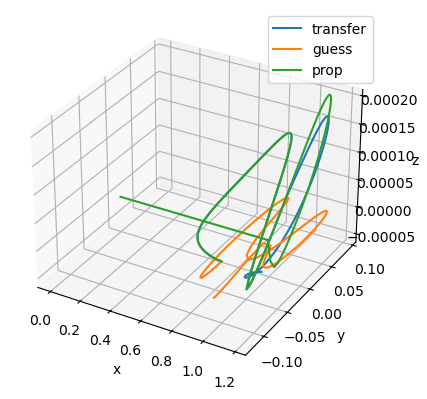

In [90]:
plt.figure()
ax = plt.axes(projection ='3d')
ax.plot(state_sol[:,0], state_sol[:,1], state_sol[:,2], label='transfer')
ax.plot(state_guess[:,0], state_guess[:,1], state_guess[:,2], label='guess')
# ax.plot(patched_solution[:, 0], patched_solution[:, 1], patched_solution[:,2], label='patched')
ax.plot(x_guess[:,0], x_guess[:,1], x_guess[:,2], label='prop')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.legend()

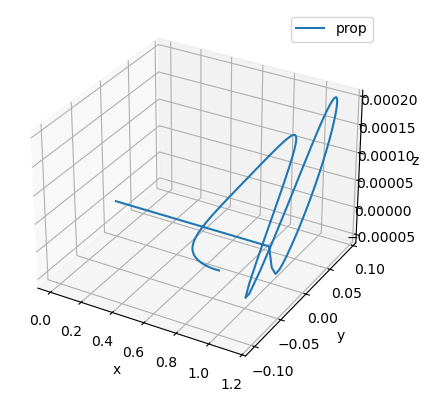

In [56]:
plt.figure()
ax = plt.axes(projection ='3d')
ax.plot(patched_solution[:, 0], patched_solution[:, 1], patched_solution[:,2], label='patched')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.legend()

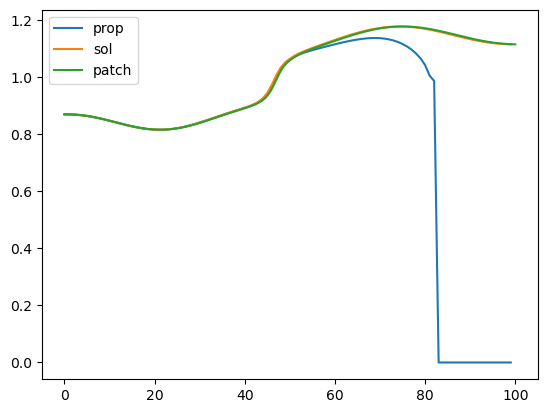

In [91]:
plt.figure()
axis_view = 0
plt.plot(range(100), x_guess[:,axis_view])
plt.plot(range(100), state_sol[:,axis_view])
plt.plot(np.linspace(0, 100, 99 * 100 + 1), patched_solution[:, axis_view])
plt.legend(['prop', 'sol', 'patch'])

In [38]:
control_guess = np.zeros([99, 3])
for i in range(0, 99):
    control_guess[i, :] = control_sol[0, :]

In [39]:
x_guess = propagation.propagate(dyn_prop, state_sol[0,:], control_guess, np.empty(0), np.linspace(time[0], time[1], 100), auxdata)


In [36]:
x_guess[-1,:] - state_sol[1,:]

array([-2.86666840e-08, -7.63780602e-08, -2.90771402e-10, -1.16915180e-06,
       -2.86593497e-06, -1.12189070e-08])

In [40]:
x_guess[-1,:] - state_sol[1,:]

array([-2.86666840e-08, -7.63780602e-08, -2.90771402e-10, -1.16915180e-06,
       -2.86593497e-06, -1.12189070e-08])

In [35]:
state_sol[1,:]

array([ 8.70107750e-01, -6.91364268e-02,  1.15563898e-05, -5.74574299e-03,
       -1.67202541e-01,  2.06663011e-04])